## Analyse de l'incidence de la varicelle en France: Version Python

## Préparation des données

Les données de l'incendence de la varicelle sont disponibles sur le site du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous la forme d'un fichier CSV dont chaque ligne correspond a une semaine de la période demandée. Nous téléchargeons le jeu de données complet qui commence en 1990 et se termine dans une semaine récente. L'URL est:

In [9]:
data_url = "https://www.sentiweb.fr/datasets/all/inc-7-PAY.csv"

Pour lutter contre les problèmes de perrénité de l'URL, nous allons télécharger en local notre jeu de données utilisé dans cette analyse pour permettre une réutilisation ultérieure.

In [95]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

POur nous protéger contre une éventuelle disparition ou modification du serveur du Réseau Sentinelle , nos faisons une copie locale des données que nous conservons avec notre analyse. Il est inutile  et risqué de faire a chaque execution un téléchargement des données; c'est pour cela que nous téléchargeons les données si le fichier local n'existe pas

In [20]:
data_file = 'varicelle.csv'
if not os.path.isfile(data_file):
    response = requests.get(data_url)
    #print(response)
    with open(data_file,'wb') as fichier:
        fichier.write(response.content)


Voici la description des données sur le [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):

<table>
    <tr> 
        <td> Nom de colonne</td>
        <td> Libellé de colonne</td>
    </tr>
    <tr> 
        <td> Week</td>
        <td> Semaine Calandaire(ISO 8601) </td>
    </tr>
</table>

### Lecture des données

Nous allons lire avec pandas les données sous forme de dataframe. Nous laissons passer la première ligne qui n'est qu'un simple commentaire

In [28]:
data_source = pd.read_csv(data_file,skiprows=1)
data_source.head()

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
0,202440,7,2582,793,4371,4,1,7,FR,France
1,202439,7,2908,1339,4477,4,2,6,FR,France
2,202438,7,751,0,1513,1,0,2,FR,France
3,202437,7,916,28,1804,1,0,2,FR,France
4,202436,7,2235,870,3600,3,1,5,FR,France


Nous allons traiter les dates pour les ramener sous un format que pandas et python comprennent. Pour cela nous faisons appel a la library `isoweek`

### Traitement des dates

In [29]:
import isoweek

In [46]:
def convert_week(week):
    week = str(week)
    iso = isoweek.Week(int(week[:4]),int(week[4:]))
    return pd.Period(iso.day(0),'W')

Nous ajoutons une colonne Period qui va contenir les périodes(semaines) de chaque observation

In [48]:
data_source['Period'] = [convert_week(week) for week in data_source["week"]]
data_source.head()

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name,Period
0,202440,7,2582,793,4371,4,1,7,FR,France,2024-09-30/2024-10-06
1,202439,7,2908,1339,4477,4,2,6,FR,France,2024-09-23/2024-09-29
2,202438,7,751,0,1513,1,0,2,FR,France,2024-09-16/2024-09-22
3,202437,7,916,28,1804,1,0,2,FR,France,2024-09-09/2024-09-15
4,202436,7,2235,870,3600,3,1,5,FR,France,2024-09-02/2024-09-08


Nous allons vérifier s'il y a de manquants dans notre dataset

In [57]:
data_source[data_source.isnull().any(axis=1)]

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name,Period


Les données sont dans un ordre chronologique décroissant alors nous allons les ordonnées

In [142]:
data_ord = data_source.set_index('Period').sort_index()
data_ord.head(3)

,week,indicator,inc,inc_low,inc_up,inc100,inc100_low,inc100_up,geo_insee,geo_name
Period,,,,,,,,,,
1990-12-03/1990-12-09,199049,7,1143,0,2610,2,0,5,FR,France
1990-12-10/1990-12-16,199050,7,11079,6660,15498,20,12,28,FR,France
1990-12-17/1990-12-23,199051,7,19080,13807,24353,34,25,43,FR,France


Nous remarquons qu'il n'y a pas de manquants. Bonne nouvelle alors. Nous allons vérifier maintenant si les périodes sont cohérents c'est a dire qu'ils se suivent

In [87]:
actual = 0
for week1,week2 in zip(data_ord.index[:-1],data_ord.index[1:]):
    delta = week2.to_timestamp() - week1.end_time
    if delta > pd.Timedelta('1s'):
        actual = 1
        print(week1,week2)
if not actual:
    print('Tout va bien. Pas de maladresse constaté')    
    

Tout va bien. Pas de maladresse constaté


On constate que les périodes se suivent très bien. Donc nous pouvons passer a une visualisation des données

### Inspection

Regardons a quoi ressemble nos données par une visualisation graphique

<Axes: xlabel='Period'>

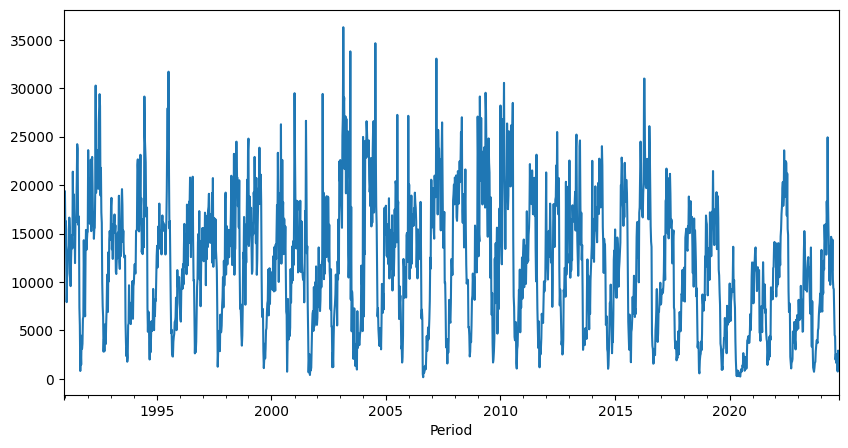

In [96]:
data_ord['inc'].plot(figsize=(10,5))

Pour mieux voir nous allons ploter uniquement pour les dernieres années

<Axes: xlabel='Period'>

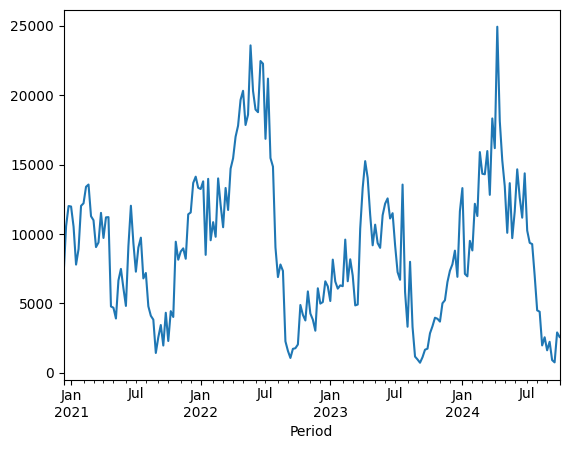

In [97]:
data_ord['inc'][-200:].plot()

## L'incidence annuelle

### Calcul

Étant donné que le pic de l'épidémie se situe en hiver, à cheval entre deux années civiles, nous définissons la période de référence entre deux minima de l'incidence, du 1er Septembre de l'année $N$ au 1er août de l'année $N+1$. Nous mettons l'année $N+1$ comme étiquette sur cette année décalée, car le pic de l'épidémie est toujours au début de l'année $N+1$. Comme l'incidence de syndrome grippal est très faible en été, cette modification ne risque pas de fausser nos conclusions.

Encore un petit detail,les données commencent en 1990, ce qui rend cette année inutilisable

In [143]:
september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W') for y in range(1991,data_ord.index[-1].year)]
september_week

[Period('1991-08-26/1991-09-01', 'W-SUN'),
 Period('1992-08-31/1992-09-06', 'W-SUN'),
 Period('1993-08-30/1993-09-05', 'W-SUN'),
 Period('1994-08-29/1994-09-04', 'W-SUN'),
 Period('1995-08-28/1995-09-03', 'W-SUN'),
 Period('1996-08-26/1996-09-01', 'W-SUN'),
 Period('1997-09-01/1997-09-07', 'W-SUN'),
 Period('1998-08-31/1998-09-06', 'W-SUN'),
 Period('1999-08-30/1999-09-05', 'W-SUN'),
 Period('2000-08-28/2000-09-03', 'W-SUN'),
 Period('2001-08-27/2001-09-02', 'W-SUN'),
 Period('2002-08-26/2002-09-01', 'W-SUN'),
 Period('2003-09-01/2003-09-07', 'W-SUN'),
 Period('2004-08-30/2004-09-05', 'W-SUN'),
 Period('2005-08-29/2005-09-04', 'W-SUN'),
 Period('2006-08-28/2006-09-03', 'W-SUN'),
 Period('2007-08-27/2007-09-02', 'W-SUN'),
 Period('2008-09-01/2008-09-07', 'W-SUN'),
 Period('2009-08-31/2009-09-06', 'W-SUN'),
 Period('2010-08-30/2010-09-05', 'W-SUN'),
 Period('2011-08-29/2011-09-04', 'W-SUN'),
 Period('2012-08-27/2012-09-02', 'W-SUN'),
 Period('2013-08-26/2013-09-01', 'W-SUN'),
 Period('20

In [145]:
year = []
incidence = []
for date1,date2 in zip(september_week[:-1],september_week[1:]):
    one_year = data_ord['inc'][date1:date2-1]
    assert abs(len(one_year)-52) < 2
    year.append(date2.year)
    incidence.append(one_year.sum())

    